In [1]:
import numpy as np
import scipy as sp
import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
import os
from matplotlib import pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
write_folder = os.path.join('/mnt','BigDisk','2P_scratch')


mouse = 'CA3-1'

file_list = ({'scene': 'YMaze_LNovel',
             'date': '23_10_2021',
             'session': 1,
             'scan': 2,
             },)

In [3]:
def check_and_make_h5s(file_list, runh5=True):
    h5list, framerates = [], []
    for f in file_list:
        print(f)
        scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
        source_folder  = os.path.join('/mnt','BigDisk','2P_scratch')
        source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
        info = tpu.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
        
        file_stem = os.path.join(write_folder,mouse,f['date'],f['scene'],scan_str)
        h5path = os.path.join(file_stem,scan_str+".h5")
        if not os.path.exists(h5path) and runh5:
            _ =  tpu.scanner_tools.sbx_utils.sbx2h5(source_stem,output_name=h5path,force_2chan=False)

        h5list.append(file_stem)
        framerates.append(info['frame_rate'])
    print(h5list)
    return h5list, framerates

In [4]:
def run_session(fdict):
    _h5list,_frs = check_and_make_h5s([fdict,],runh5=True)
    ops_dir = os.path.join(_h5list[0],'suite2p','plane0','ops.npy')
    s2p_dir = os.path.join(_h5list[0],'suite2p','plane0')

    ops = tpu.s2p.set_ops(d={'data_path': _h5list,
                                   'save_path0': _h5list[0],
                                    'fast_disk':[],
                                    'move_bin':True,
                                    'two_step_registration':True,
                                    'maxregshiftNR':10,
                                    'tau':.7,
                                    'functional_chan':1,
                                    'fs':_frs[0],
                                    'roidetect':True,
                                    'input_format':"h5",
                                    'h5py_key':'data',
                                    'nchannels':1,
                                    'threshold_scaling':1,
                                     'nplanes': 2,
                                    'chan2_thresh':.01})
    ops=s2p.run_s2p(ops=ops)
    !rm {_h5list[0]}/*.h5 


for f in file_list: #file_list:
    
    if isinstance(f,tuple):
        for _f in f:
            run_session(_f)
    else:
        run_session(f)

{'scene': 'YMaze_LNovel', 'date': '23_10_2021', 'session': 1, 'scan': 2}


KeyboardInterrupt: 

In [21]:
def update_sess_dict(mouse, f):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])

            
    source_folder = "/mnt/BigDisk/2P_scratch"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("/home/mplitt/VR_scratch",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
             })
    return f

def run_and_save(fdict,comb_frames=0):
#     with open(os.path.join('/home/mplitt/YMazeSessPkls',mouse,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),'rb') as file:
#         sess = dill.load(file)
#     sess.novel_arm = fdict['novel']    
            
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info()
    sess.align_VR_to_2P()
    sess.load_suite2p_data(which_ts=('F', 'Fneu','spks'), frames = slice(comb_frames,comb_frames+sess.scan_info['max_idx']))
    sess.get_trial_info()
#     sess.neuropil_corrected_dff()
    
    
#     sess.place_cells_calc(nperms=1000)
    
#     sess.add_pos_binned_trial_matrix('F_dff')
#     sess.add_timeseries(F_dff_norm = sess.timeseries['F_dff']/np.nanpercentile(sess.timeseries['F_dff'],99,axis=1,keepdims=True))
#     sess.rm_pos_binned_trial_matrix('F_dff_norm')
#     sess.add_pos_binned_trial_matrix('F_dff_norm')
    
    sess.add_pos_binned_trial_matrix('spks') #,speed=sess.vr_data['dz']._values, speed_thr = .05)  
    fig,ax = plt.subplots()
#     ax.imshow(sess.timeseries['spks' ],aspect = 'auto')
    sess.add_timeseries(spks_norm = sess.timeseries['spks']/np.nanpercentile(sess.timeseries['spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('spks_norm') 
    ax.imshow(sess.timeseries['spks_norm' ],aspect = 'auto')

    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')
    
    tpu.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')
    return comb_frames+sess.scan_info['max_idx']

Fixing teleports
(173237,) (36420,)
2348.4491813602017 2348.4292191435766


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:189: UserWarning: one frame correction
  warnings.warn('one frame correction')


multiple planes functionality not added in yet, assuming 1 plane
/mnt/BigDisk/2P_scratch/CA3-1/23_10_2021/YMaze_LNovel/YMaze_LNovel_001_002/suite2p


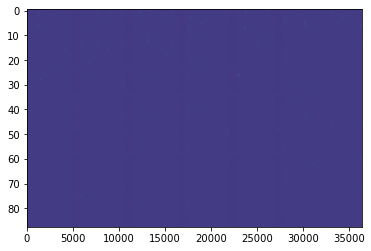

In [22]:
f_ = update_sess_dict(mouse,file_list[0])
_ = run_and_save(f_)

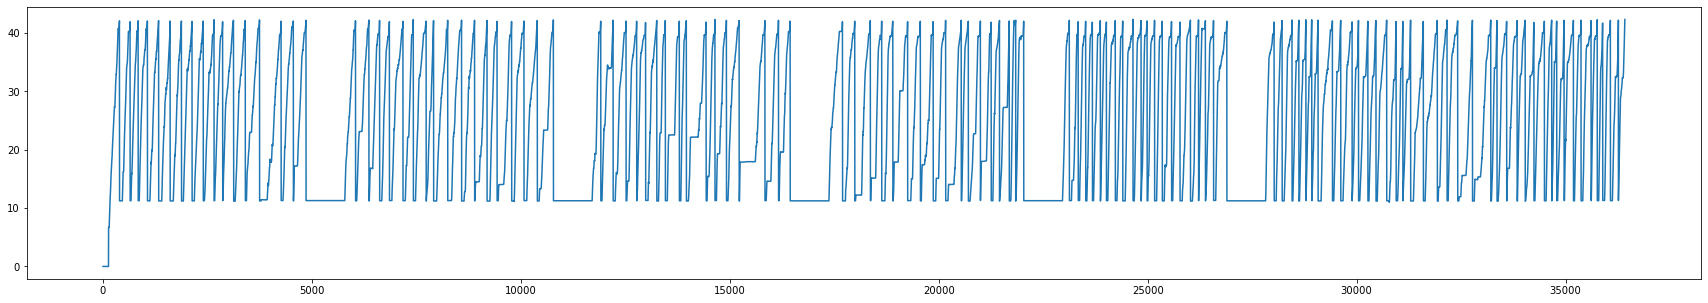

In [23]:
sess = stx.session.YMazeSession.from_file(os.path.join("/home/mplitt/YMazeSessPkls", mouse, f_['date'], "%s_%d.pkl" % (f_['scene'], f_['session'])))
fig, ax = plt.subplots(figsize = [30,5])
ax.plot(sess.vr_data['t'])




<ipython-input-31-8609c300b9b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


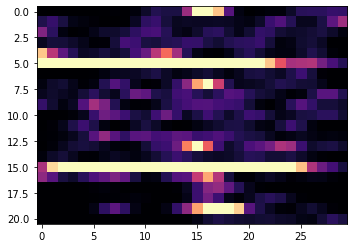

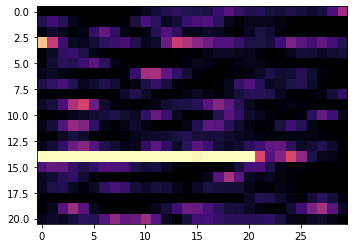

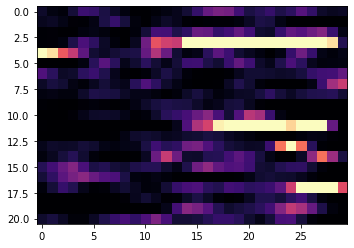

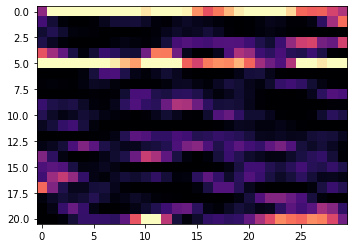

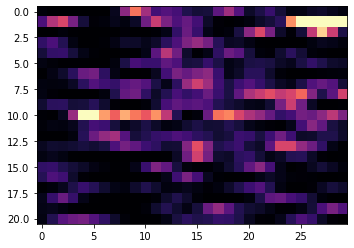

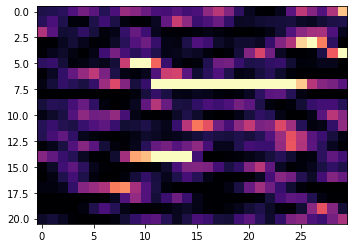

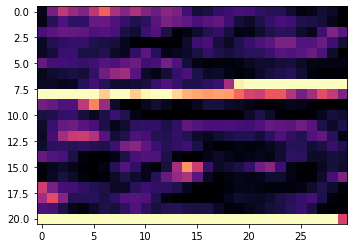

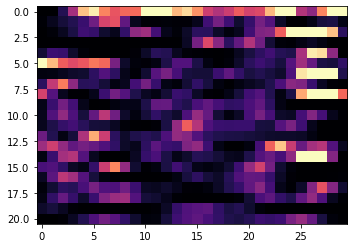

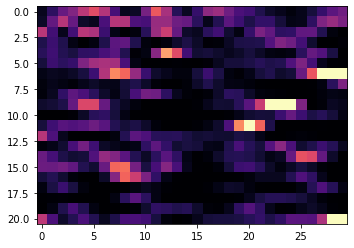

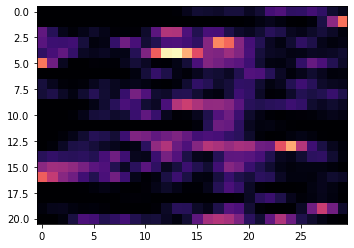

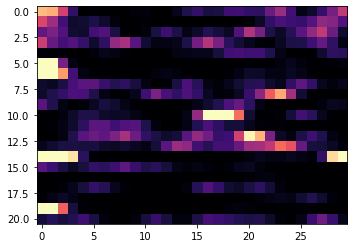

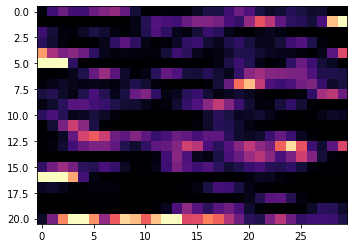

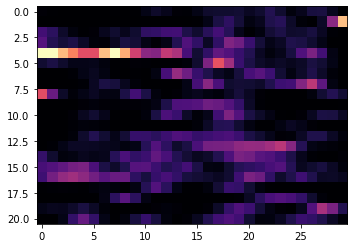

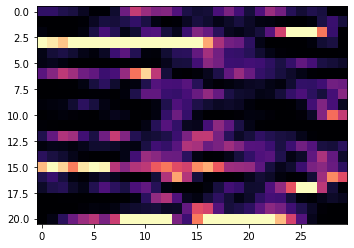

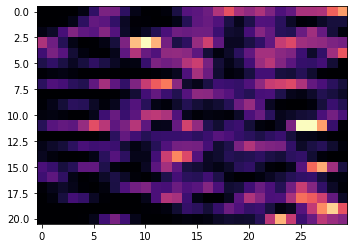

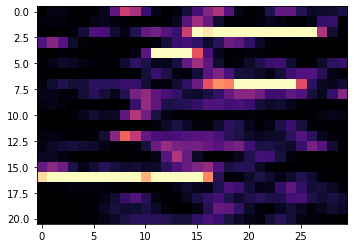

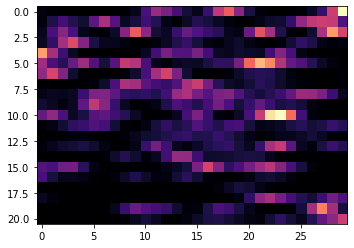

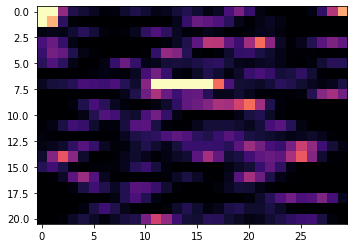

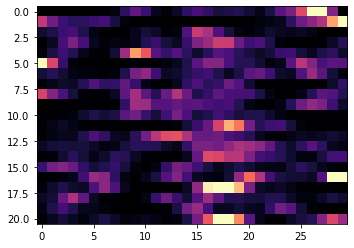

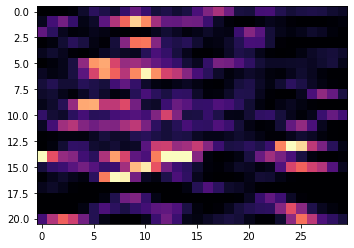

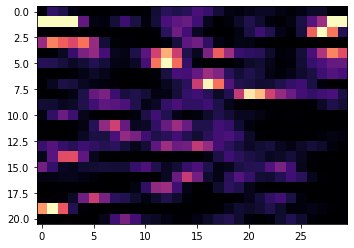

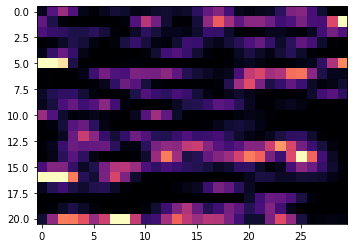

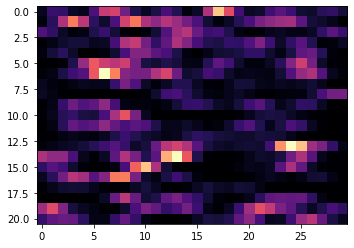

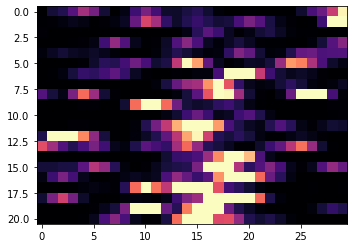

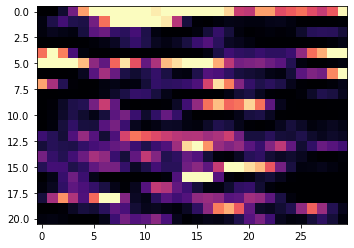

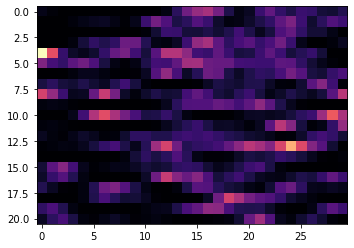

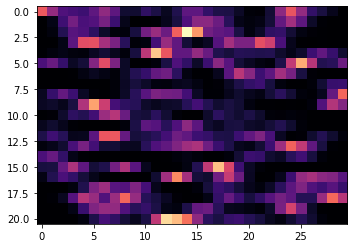

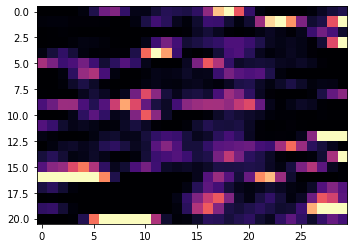

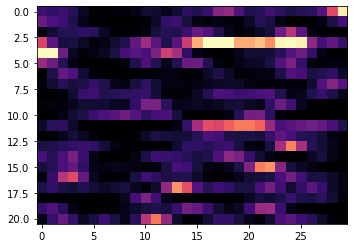

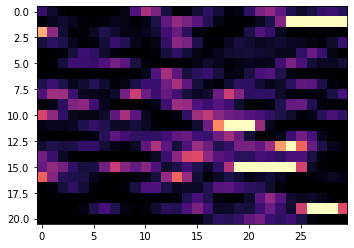

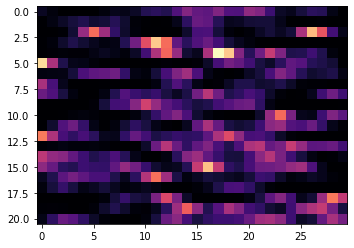

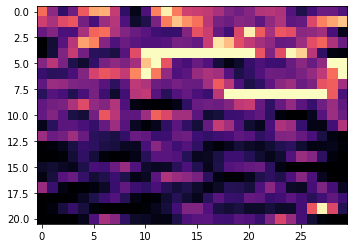

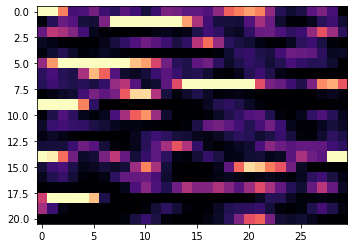

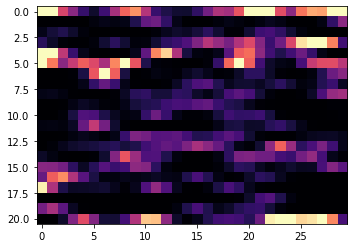

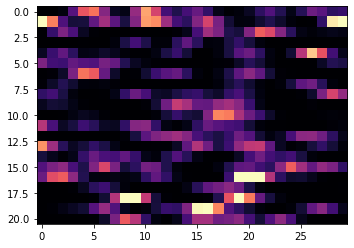

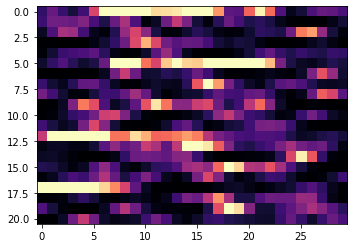

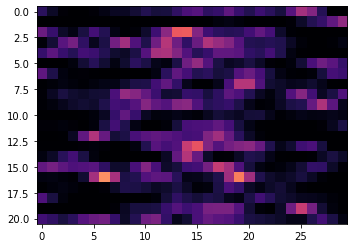

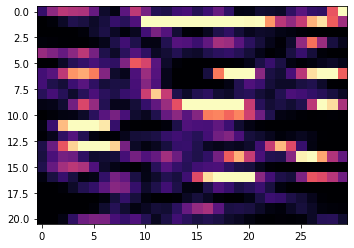

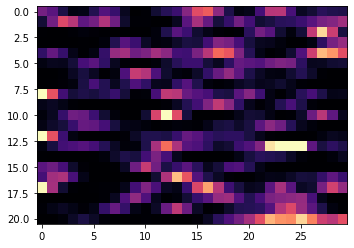

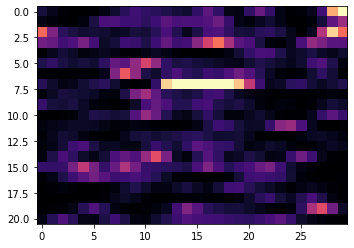

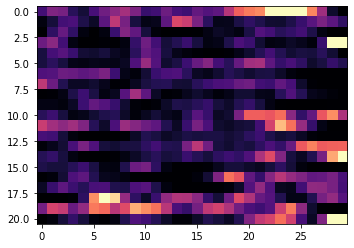

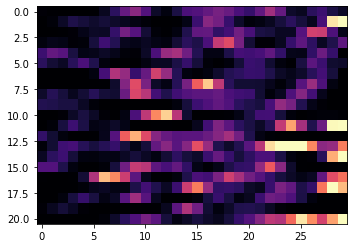

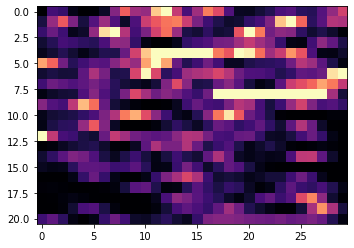

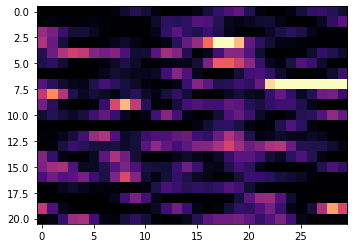

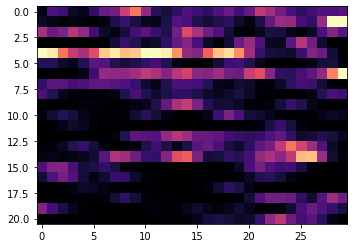

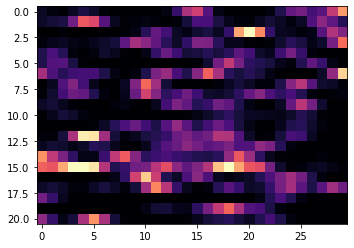

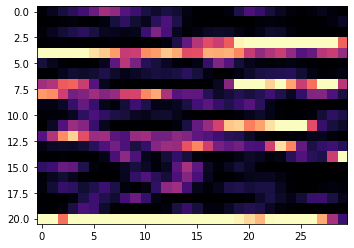

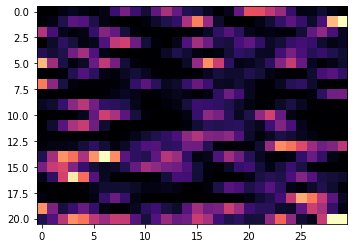

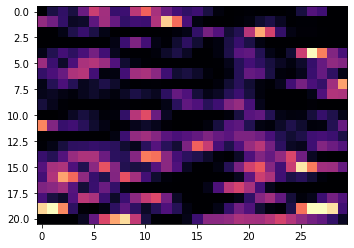

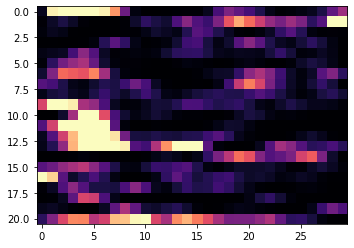

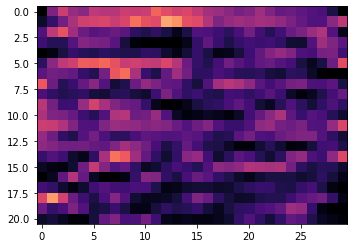

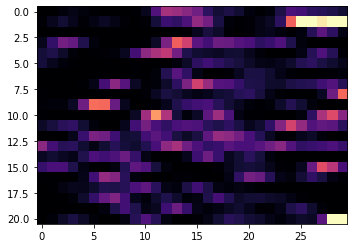

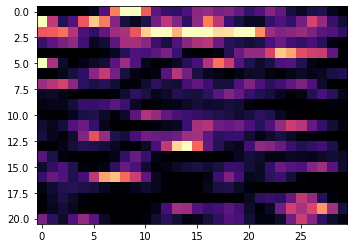

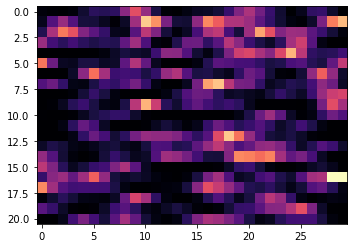

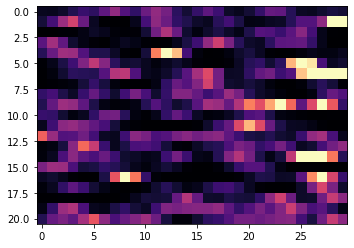

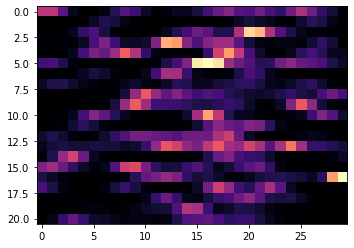

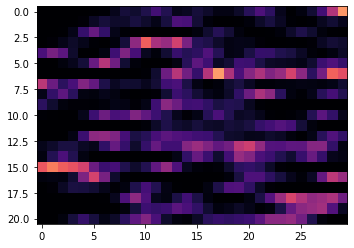

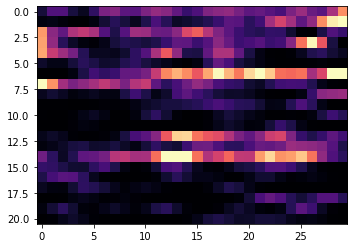

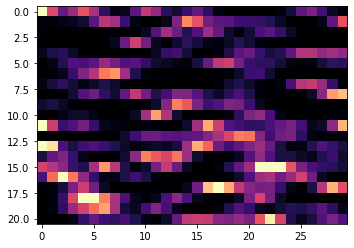

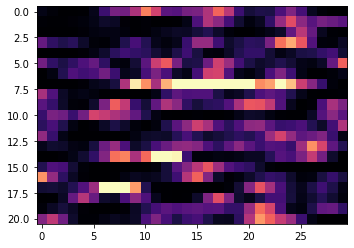

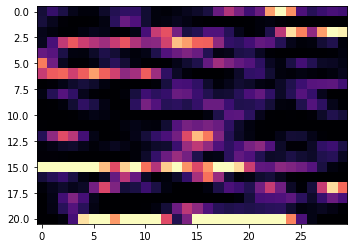

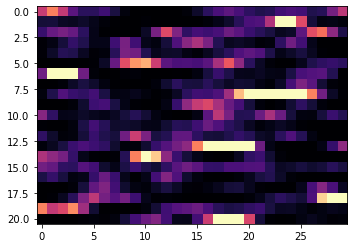

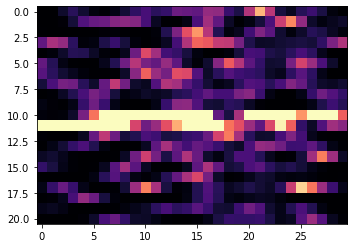

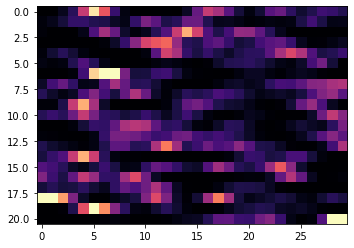

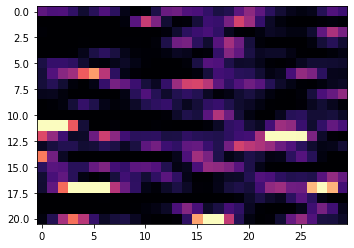

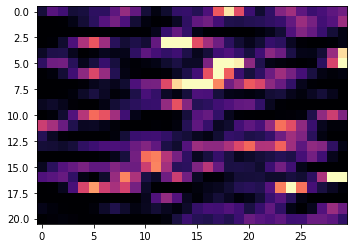

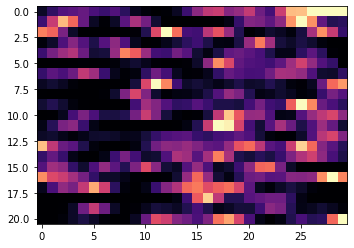

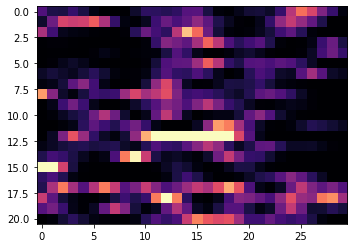

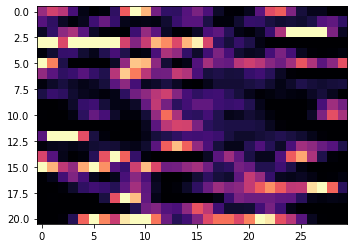

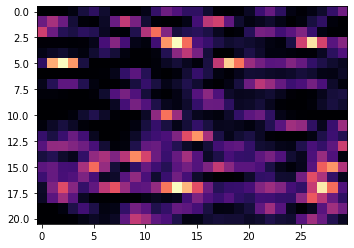

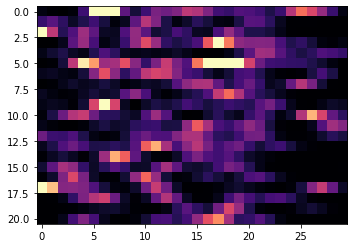

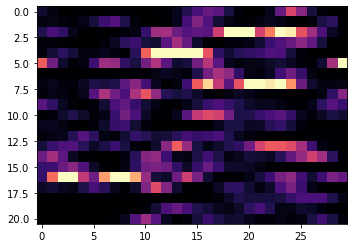

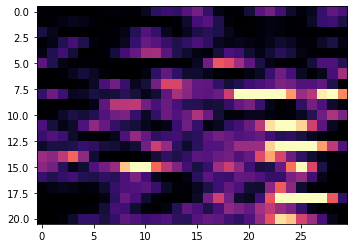

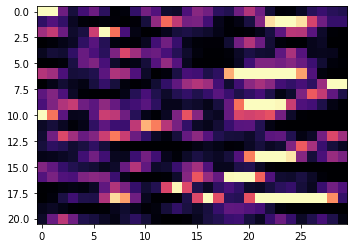

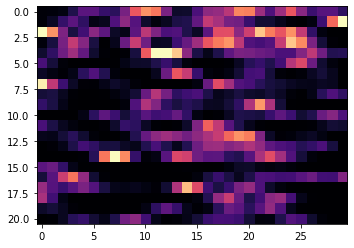

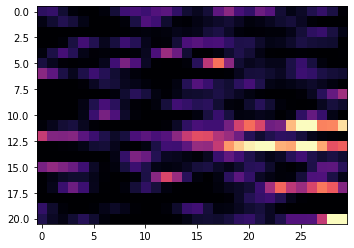

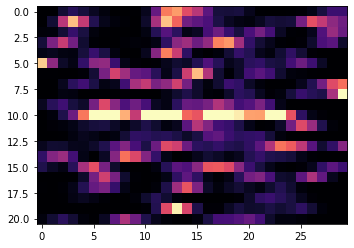

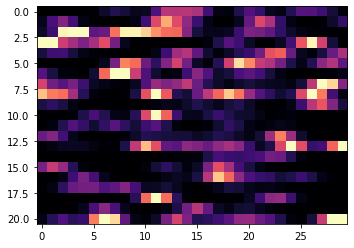

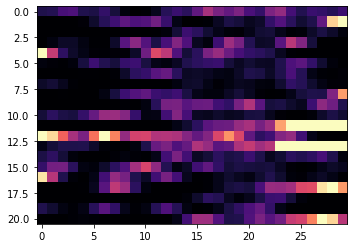

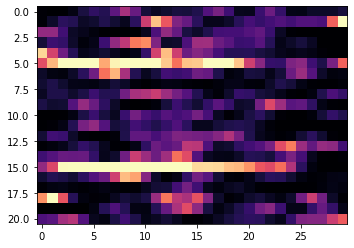

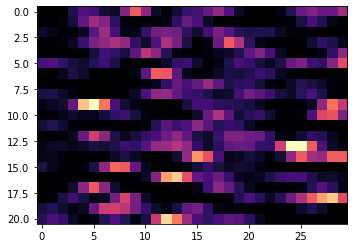

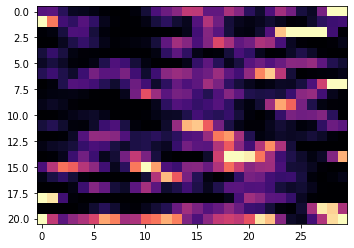

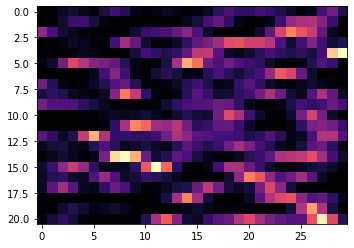

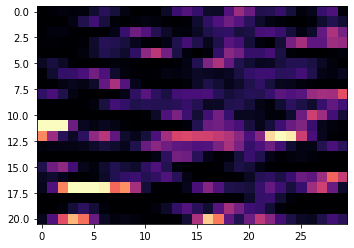

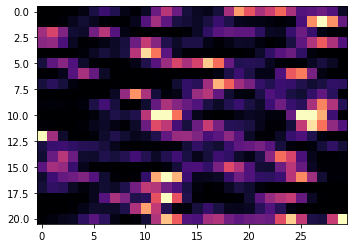

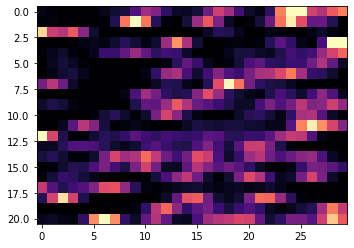

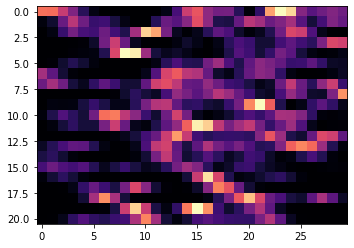

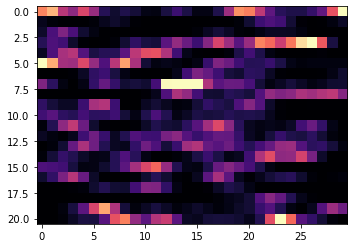

In [31]:
spkmat = sess.trial_matrices['spks_norm']
spkmat[np.isnan(spkmat)]=1E-3
spkmat /= spkmat.mean(axis=0,keepdims=True).mean(axis=1,keepdims=True)
spkmat_sm = sp.ndimage.filters.gaussian_filter1d(spkmat,1,axis=1)
for cell in range(sess.trial_matrices['spks_norm'].shape[-1]):
    fig,ax = plt.subplots()
    ax.imshow(spkmat_sm[sess.trial_info['LR']==-1,:,cell],cmap = 'magma',vmin=0,vmax=5)

In [ ]:
# left_pcs = sess.place_cell_info['left']['masks']
# right_pcs = sess.place_cell_info['right']['masks']
    # plt the place cells
fig, ax = plt.subplots(2,2, figsize=[10,10])

# left trials
trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==-1,:,:][:,:,left_pcs]
# sort by odd trials
sort_vec = np.argsort(np.argmax(np.nanmean(trial_mat[::2,:,:],axis=0), axis=0))
ax[0,0].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
ax[0,0].plot([-0.5,trial_mat.shape[1]-.5], [-.5,trial_mat.shape[2]-.5])
ax[0,0].set_ylabel('Cells')
ax[0,0].set_xlabel('Positions')
ax[0,0].set_title('Left Trials')
# right trials (left sort)
trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==1,:,:][:,:,left_pcs]
ax[0,1].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
ax[0,1].set_ylabel('Cells')
ax[0,1].set_xlabel('Positions')
ax[0,1].set_title('Right Trials (Left Trial Sort)')


#right 
trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==1,:,:][:,:,right_pcs]
# sort by odd trials
sort_vec = np.argsort(np.argmax(np.nanmean(trial_mat[::2,:,:],axis=0), axis=0))
ax[1,1].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
ax[1,1].plot([-0.5,trial_mat.shape[1]-.5], [-.5,trial_mat.shape[2]-.5])
ax[1,1].set_ylabel('Cells')
ax[1,1].set_xlabel('Positions')
ax[1,1].set_title('Right Trials')


# left trials (right sort)
trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==-1,:,:][:,:,right_pcs]
ax[1,0].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
ax[1,0].set_ylabel('Cells')
ax[1,0].set_xlabel('Positions')
ax[1,0].set_title('Left Trials (Right Trial Sort)')